In [2]:
import pandas as  pd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sktree import ObliqueRandomForestClassifier, PatchObliqueRandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
import scipy.stats as ss

In [3]:
df = pd.read_excel('/cis/home/jdey4/data_MRI/subjects_age_sex_data_MRI.xlsx')
df.head()

,ID,Age,Sex,Dataset,Dataset-ID
0,sub-ABIDE1050339,18.0000,MALE,ABIDE,50339
1,sub-ABIDE1050701,18.0000,MALE,ABIDE,50701
2,sub-ABIDE1050445,18.1383,MALE,ABIDE,50445
3,sub-ABIDE1050459,18.1547,MALE,ABIDE,50459
4,sub-ABIDE1050341,18.2000,FEMALE,ABIDE,50341


In [4]:
df_quality = pd.read_csv('/cis/home/jdey4/data_MRI/QC_catreport.csv')
df_quality.head()

,sub,Weighted average (IQR),Warning
0,sub-A00008326,83.86,0
1,sub-A00008399,83.3,0
2,sub-A00010893,78.3,0
3,sub-A00013809,79.36,0
4,sub-A00018030,84.05,0


### Load the mask

In [4]:
mask = nb.load('/cis/home/jdey4/data_MRI/template_cat12/brainmask.nii').get_fdata()

Text(0.5, 1.0, 'Mask (Traverse)')

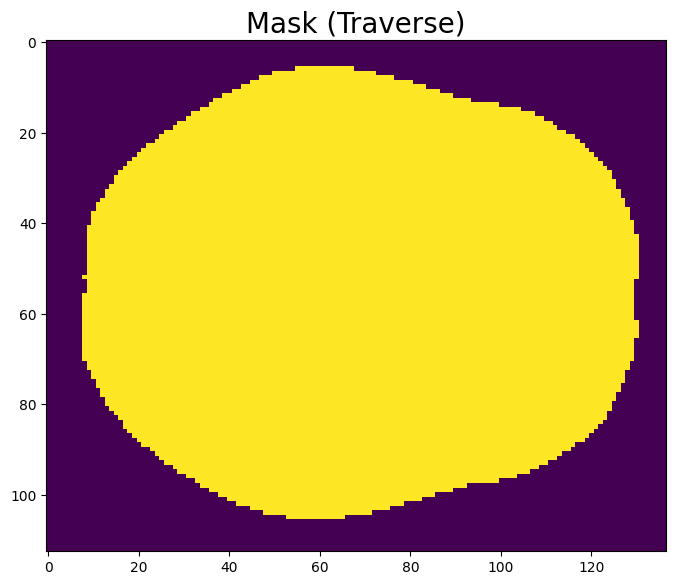

In [5]:
slice=50
sliced_img = mask[:,:,slice]

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(sliced_img)

ax.set_title('Mask (Traverse)', fontsize=20)

In [6]:
idx = np.where(mask.reshape(-1)>0)[0]

### Load data and build (feature, label)

In [7]:
path = '/cis/home/jdey4/data_MRI/'
subjects = os.listdir(path)
X = []
y = []
file_no = 0
IDs = set(df['ID'])
quality_ID = set(df_quality['sub'])
for subject in tqdm(subjects):
    if subject in IDs and subject in quality_ID:
        #print(df[df['ID']==subject]['Sex'])
        IQR = list(df_quality[df_quality['sub']==subject]['Weighted average (IQR)'])[0]
        
        if IQR is np.nan:
            continue
            
        if IQR[-1] == '%':
            continue
        
        if float(IQR) < 60:
            continue
            
        gender = list(df[df['ID']==subject]['Sex'])
        sex = int(gender[0]=='FEMALE')
        
        
        current_file = os.path.join(path, subject)
        tmp = []
        save = True
        for file in glob.glob(current_file+'/mri/*'):
            try:
                img = nb.load(file).get_fdata()
                file_no += 1
                tmp.append(img.reshape(-1))
            except:
                save = False
                print(file,' corrupted')

        '''if len(tmp)<2:
            print(subject, ' has less files')'''
            
        if save and len(tmp)==2:
            X.append(np.array(tmp).reshape(1,-1))
            y.append(sex)
    
X = np.concatenate(X,axis=0)

100%|█████████████████████████████████████████████████████████| 14471/14471 [20:40<00:00, 11.66it/s]


In [8]:
X.shape

(2206, 3498706)

In [9]:
np.mean(y)

0.5485040797824116

## Train MORF

In [18]:
total_models = 1000
x_train_, x_test, y_train_, y_test = train_test_split(
                        X, y, train_size=.8,random_state=0, stratify=y)
for ii in tqdm(range(total_models)):
    x_train, _, y_train, _ = train_test_split(
                        x_train_, y_train_, train_size=.7,random_state=ii, stratify=y_train_)
    
    morf = PatchObliqueRandomForestClassifier(n_estimators=1, max_patch_dims=np.array((4, 4, 4)), data_dims=np.array((113, 137, 113)), n_jobs=-1)
    morf.fit(x_train[:,:113*137*113], y_train)

    with open('morf_models/model'+str(ii)+'.pickle','wb') as f:
        pickle.dump(morf, f)

    del morf

 66%|███████████████████████████████▊                | 664/1000 [12:59:53<6:34:38, 70.47s/it]


KeyboardInterrupt: 

In [13]:
x_train_, x_test, y_train_, y_test = train_test_split(
                        X, y, train_size=.8,random_state=0, stratify=y)

predicted_proba_ = []
total_models = 650
for ii in tqdm(range(total_models)):
    with open('morf_models/model'+str(ii)+'.pickle','rb') as f:
        morf = pickle.load(f)
        predicted_proba_.append(
            morf.predict_proba(x_test[:,:113*137*113])
        )
        del morf

predicted_proba = np.mean(predicted_proba_,axis=0)
predicted_label = np.argmax(predicted_proba,axis=1)
print('MORF accuracy', np.mean(predicted_label==y_test))

MORF accuracy 0.8642533936651584


## Train MORF with shuffled label

In [14]:
total_models = 650
x_train_, x_test, y_train_, y_test = train_test_split(
                        X, y, train_size=.8,random_state=0, stratify=y)
for ii in tqdm(range(total_models)):
    x_train, _, y_train, _ = train_test_split(
                        x_train_, y_train_, train_size=.7,random_state=ii, stratify=y_train_)

    random.shuffle(y_train)
    morf = PatchObliqueRandomForestClassifier(n_estimators=1, max_patch_dims=np.array((4, 4, 4)), data_dims=np.array((113, 137, 113)), n_jobs=-1)
    morf.fit(x_train[:,:113*137*113], y_train)

    with open('morf_shuffled_models/model'+str(ii)+'.pickle','wb') as f:
        pickle.dump(morf, f)

    del morf

100%|██████████████████████████████████████████████████████████| 650/650 [13:46:30<00:00, 76.29s/it]


### Find the feature importance

In [5]:
total_models = 100
feature_imp = []
for ii in tqdm(range(total_models)):
    with open('morf_models/model'+str(ii)+'.pickle','rb') as f:
        morf = pickle.load(f)
        feature_imp.append(
            morf.feature_importances_
        )
        del morf

for ii in tqdm(range(total_models)):
    with open('morf_shuffled_models/model'+str(ii)+'.pickle','rb') as f:
        morf = pickle.load(f)
        feature_imp.append(
            morf.feature_importances_
        )
        del morf

100%|████████████████████████████████████████████████| 100/100 [2:41:10<00:00, 96.70s/it]


In [6]:
feature_imp = np.array(feature_imp)

In [45]:
reps = 1000

stat = np.zeros(len(feature_imp[0]))
for ii in range(total_models):
    r = ss.rankdata(
            1-feature_imp[ii], method='max'
        )
    r_0 = ss.rankdata(
            1-feature_imp[total_models+ii], method='max'
        )

    stat += (r_0 > r)*1

count = np.zeros(len(feature_imp[0]))
for _ in tqdm(range(reps)):
    idx = list(range(2*total_models))
    random.shuffle(idx)
    stat1 = np.zeros(len(feature_imp[0]))
    
    for ii in range(total_models):
        r1 = ss.rankdata(
                1-feature_imp[idx[ii]], method='max'
            )
        r1_0 = ss.rankdata(
                1-feature_imp[idx[total_models+ii]], method='max'
            )
    
        stat1 += (r1_0 > r1)*1
        
    count += (stat1>=stat)*1

p_val = (1 + count)/(1+reps)

100%|██████████████████████████████████████████████| 1000/1000 [3:19:51<00:00, 11.99s/it]


In [64]:
'''id_accept = np.where(p_val>0.05)[0]
id_reject = np.where(p_val<=0.05)[0]

feature_map = np.zeros(len(feature_imp[0]))
feature_map[id_reject] = 1'''
feature_map = -np.log(p_val)

In [65]:
demo_filepath_whitematter = '/cis/home/jdey4/data_MRI/sub-A00008326/mri/mwp2sub-A00008326_T1w.nii'
demo_filepath_graymatter = '/cis/home/jdey4/data_MRI/sub-A00008326/mri/mwp1sub-A00008326_T1w.nii'

img_whitematter = nb.load(demo_filepath_whitematter).get_fdata()
img_graymatter = nb.load(demo_filepath_graymatter).get_fdata()

In [66]:
brain_img = feature_map.reshape(113,137,113)

Text(0.5, 1.0, 'gray matter (Traverse)')

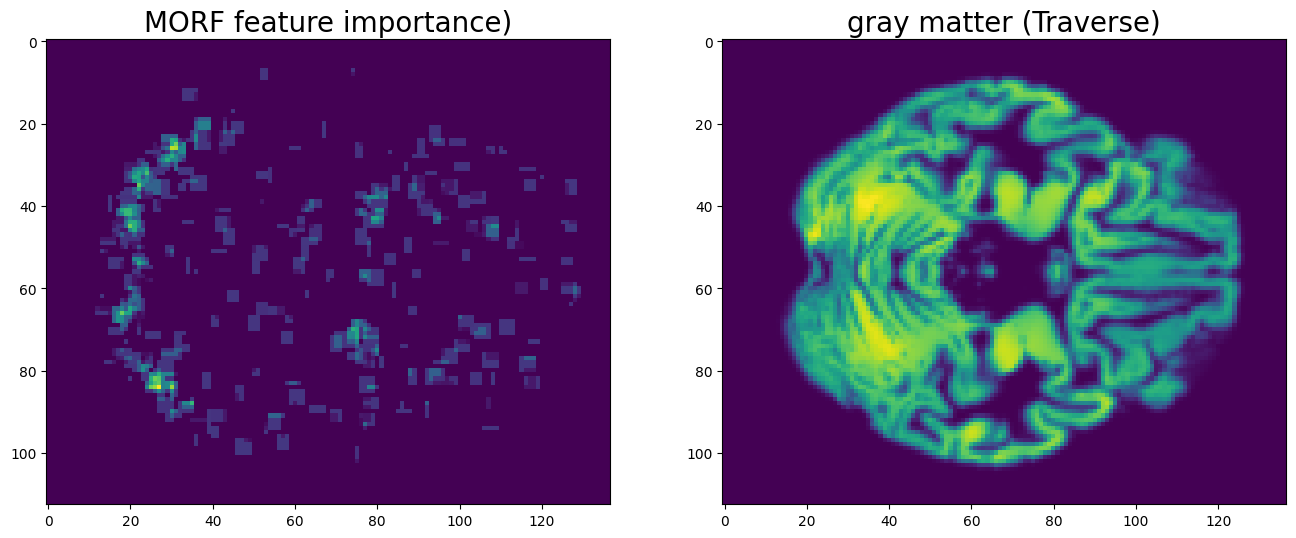

In [72]:
slice = 35

sliced_img_whitematter = img_whitematter[:,:,slice]
sliced_img_graymatter = img_graymatter[:,:,slice]

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(brain_img[:,:,slice])
ax[1].imshow(sliced_img_graymatter)

ax[0].set_title('MORF feature importance)', fontsize=20)
ax[1].set_title('gray matter (Traverse)', fontsize=20)

In [53]:
img_white = nb.load(demo_filepath_whitematter)
img = nb.Nifti1Image(brain_img, header = img_white.header, affine = img_white.affine)

nb.save(img, 'feature_imp_rank.nii')